# Notebook 06. Introduction to RL applied to Recommender Systems

© 2019-2022, Anyscale. All Rights Reserved <br>
📖 [Back to Table of Contents](./ex_00_rllib_notebooks_table_of_contents.ipynb)<br>
➡️ [Next notebook](./ex_07_rllib_end_to_end_demo.ipynb) <br>
⬅️ [Previous notebook](./ex_05_rllib_and_ray_serve.ipynb) <br>

### Learning objectives
In this this tutorial, you will learn how to:

 * [Understand the Benefits of RL in a Recommender System](#recsys_rl)
 * [Create a RecSys RL environment](#recsys_env)
 * [Train a Contextual Bandit on the environment](#cb)
 * [Train using a SlateQ algorithm on the environment](#slateq)
 

## Benefits of RL in a Recommender System <a class="anchor" id="recsys_rl"></a>

A Recommender System <b>(RecSys)</b> suggests items that are most pertinent to a particular user.  Examples of recommender systems include:
<ul>
    <li>Movie/video/music recommendations (Netflix/YouTube/Spotify)</li>
    <li>Online shopping recommendations (Amazon/Shopify)</li>
    <li>Filtering your feed as you scroll (Twitter/Instagram)</li>
</ul>

<b>Two main approaches to training algorithms</b> for RecSys are: 
<ol>
    <li>Traditional Machine Learning <b>(ML)</b></li>
    <li>Reinforcement Learning <b>(RL)</b></li>
    </ol>

In the <b>traditional ML</b> method, data is gathered about users interactions with items.  Often this is represented as a <b>large, sparse matrix A</b> (rows are users, items are columns, elements of aij are the interactions).  <b>Matrix factorization (A = U * VT)</b> is often used to transform A into <i>trainable representations of users (U) and items (V)</i>, where U,V can be thought of as "embeddings" or features or X's.  Solving the matrix factorization problem turns into solving the quadratic minimization of frobenius-norm(A - U*VT).  Computationally this is solved using SGD Stochastic gradient descent (SGD), or Weighted Alternating Least Squares (WALS) which is the more parallelizable method of the two.  <br>

Solving the matrix factorization problem is often referred to as <b><i>collaborative filtering</i></b>.  The algorithm is trained on all the data at once, which is extremely efficient.  But this means the traditional supervised learning model is <b>static with respect to time</b>. This can produce models that are:
- too shortsighted or 
- overlook important and changing user intents or business conditions such as seasonality or promotional campaigns.

<b>In RL</b>, users interact with offers repeatedly over time.  This <b><i>dynamic</i></b> model is iteratively trained based on observations, actions, and rewards.  
> RL algorithms have become the de facto standard ML approach for solving sequential decision-making problems based on multiple goals that can be short-term and long-term.
 
One caveat with RL, due to the sequential decision making process, <i>RL needs to calculate a new recommendation at every time step</i>.  This means to use RL efficiently, it is best to <b>restrict the data in a RL environment to only a pre-selected handful of top candidate items per user</b>.  <br>

This makes RL a good fit in a Recommender system where a traditional ML ranking model already exists.  RL can be plugged into the last, interactive part of the RecSys system, as either <b>online</b> or <b>offline RL</b>.  
> With both types of RL, “serendipitous” aspects of user experience can be explored, since random actions the user did not historically take can be tried in the simulation.

<img src="./images/recsys_overview.png" width="100%"/>

- <b>Online RL in RecSys</b> takes as input the top-K ranked and ordered recommendations per user, keeps the user and item feature embeddings as context, and optimizes a sequence of user in-session interactions using <b> real-time, live results</b>. 

- <b>Offline RL in RecSys</b> uses offline data to explore a previous training run (or production) recommender model policy, implicitly through the data.  

<div class="alert alert-block alert-success">    
    <b>💡 Online vs Offline RL, when the algorithm learning from an environment is: </b> <br><br>
    ✔️ live (typically gaming platforms or complex systems simulations), this is called <b>online RL</b> and evaluation during training is <b>on-policy</b>. The live environment could be used for simulation learning purposes or it could be in production. <br><br>
    ✔️ trained using data (could be log files of users interactions with items) converted into trajectory sequences of tuples, this is called <b>offline RL</b> and evaluation during training is <b>off-policy</b>, because the policy (RL word for model) used to log the data is different from the policy used to explore the data. Off-policy evaluation is also called <b>counterfactual evaluation</b>.</b> 
</div>

<br>

## Create a RecSys RL Environment <a class="anchor" id="recsys_env"></a>

As we learned in the first 2 lessons, the first step to learning a RL policy is to create an <b>environment</b> that can be used to train a RL algorithm. 

In this notebook, we will use <b><a href="https://github.com/google-research/recsim">Google's RecSim environment</a></b>, which was developed for the YouTube recommendation problem.  It is a configurable environment, where ideally you would plug in your own users, products, and embedding features.

- <a href="https://github.com/ray-project/ray/blob/master/rllib/env/wrappers/recsim.py">RLlib implementation</a>
- <a href="https://github.com/ray-project/ray/blob/master/rllib/examples/recommender_system_with_recsim_and_slateq.py">RLlib example</a>
- <a href="https://github.com/google-research/recsim">RecSim github</a>
- <a href="https://arxiv.org/pdf/1909.04847.pdf">RecSim paper</a>

The environment is <i>Timelimit-based</i>, meaning the termination condition for an episode will be after a fixed number (60) of videos are watched. The RecSim environment consists of:
<br>

<img src="./images/recsim_environment.png" width="100%" />

- <b>Documents</b>, with features sampled in the range [0, 1] .  In this tutorial, we use <b>1 single feature "sweetness"</b> drawn from a gaussian distribution.
> - The documents can be different at each step (produced by some "candidate generation" process), or fixed throughout the simulation.
> - The recommendation algorithm observes the D candidate documents.  It then makes a selection (possibly ordered) of k documents and presents them in a "slate" to the user.

- <b>Users</b>, with no features in this tutorial.
> - The user examines a "slate" of recommended items and makes a choice of one item. After making their choice, the user emits an observation, which the recommender can use to learn for the next recommendation. 
> - The <b>user's long-term satisfaction is explicitly revealed as a numerical reward</b> at each time step of the simulation.
- <b>Satisfaction</b> mechanism.  Think of this like a "sugar-level".  Based on the user's current sugar level, consuming a sweet item may or may not increase their long-term satisfaction (LTS).  <b>LTS stochastically (and slowly) decreases with the consumption of items containing high sweetness</b>. 

<b>RLlib comes with 3 RecSim environments</b>  <br>
<div class="alert alert-block alert-success">    
👉 <b>Long Term Satisfaction</b> (used in this tutorial) <br>
- Interest Evolution <br>
- Interest Exploration <br>
</div>

<br>

In [1]:
# import libraries
import random
import time
import numpy as np
from scipy.stats import linregress, sem
import pandas as pd
import matplotlib.pyplot as plt
import ray
from ray import tune
from ray.tune.logger import pretty_print
from pprint import pprint
print(f"ray: {ray.__version__}")

# silence the many tensorflow warnings
import logging, os
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
import tensorflow as tf
import gym
import recsim

print(f"tensorflow: {tf.__version__}")
print(f"gym: {gym.__version__}")

# Import the built-in RecSim exapmle environment: "Long Term Satisfaction", ready to be trained by RLlib.
from ray.rllib.examples.env.recommender_system_envs_with_recsim import LongTermSatisfactionRecSimEnv


ray: 2.0.0rc1
tensorflow: 2.9.1
gym: 0.21.0


In [2]:
# How to make RecSim environments?

# Env config with 10 candidate items and a slate-size of 1.

# Step 1. define a config dictionary
env_config_10 = {
    # The number of possible documents/videos/candidates that we can recommend
    # no flattening necessary (see `convert_to_discrete_action_space=False` below)
    "num_candidates": 10,  
    # The number of recommendations that we will be making
    "slate_size": 1,  # MultiDiscrete([20, 20]) -> Discrete(400)
    # Set to False for re-using the same candidate doecuments each timestep.
    "resample_documents": True,
    # Use consistent seeds for the environment ...
    "seed": 0,}

# Step 2. create a RecSim environment
lts_10_1_env = LongTermSatisfactionRecSimEnv(env_config_10)

print(type(lts_10_1_env))


<class 'ray.rllib.env.wrappers.recsim.make_recsim_env.<locals>._RecSimEnv'>


In [3]:
# print gym Spaces
if isinstance(lts_10_1_env.action_space, gym.spaces.Space):
    print()
    print(f"action space: {lts_10_1_env.action_space}")
if isinstance(lts_10_1_env.observation_space, gym.spaces.Space):
    print()
    pprint(f"observation space = {lts_10_1_env.observation_space}")

# Start a new episode and look at an observation.
obs = lts_10_1_env.reset()
print()
pprint(f"initial obs = {obs}")
print(f"engagement={np.sum(obs['response'][0]['engagement']):.4f}")

action = lts_10_1_env.action_space.sample()
next_obs, reward, done, _ = lts_10_1_env.step(action)
print()
print("Take a random action...")
print(f"action = {action}; reward = {reward:.2f}; done = {done}")
pprint(f"next obs = {next_obs}")
print(f"engagement={np.sum(next_obs['response'][0]['engagement']):.4f}")


action space: MultiDiscrete([10])

('observation space = Dict(user:Box([], [], (0,), float32), '
 'doc:Dict(0:Box([0.], [1.], (1,), float32), 1:Box([0.], [1.], (1,), float32), '
 '2:Box([0.], [1.], (1,), float32), 3:Box([0.], [1.], (1,), float32), '
 '4:Box([0.], [1.], (1,), float32), 5:Box([0.], [1.], (1,), float32), '
 '6:Box([0.], [1.], (1,), float32), 7:Box([0.], [1.], (1,), float32), '
 '8:Box([0.], [1.], (1,), float32), 9:Box([0.], [1.], (1,), float32)), '
 'response:Tuple(Dict(click:Discrete(2), engagement:Box(0.0, 100.0, (), '
 'float32))))')

("initial obs = OrderedDict([('user', array([], dtype=float32)), ('doc', {'0': "
 "array([0.79172504], dtype=float32), '1': array([0.5288949], dtype=float32), "
 "'2': array([0.56804454], dtype=float32), '3': array([0.92559665], "
 "dtype=float32), '4': array([0.07103606], dtype=float32), '5': "
 "array([0.0871293], dtype=float32), '6': array([0.0202184], dtype=float32), "
 "'7': array([0.83261985], dtype=float32), '8': array([0.77815676

Now let us manually recommend some items (select some actions), send them to the environment, and record the rewards and next observations.  

It is always a good idea to make sure you understand your environment well before using it to train a RL algorithm.

> 👉 Exercise: Execute the following cell a couple of times chosing different actions (from 0 - 9) to be sent into the environment's step() method. Each time, look at the returned next observation, reward, and done flag and write down what you find interesting about the dynamics and observations of this environment.

In [6]:
# Let's send our first action (1-slate back into the env) using the env's `step()` method.
action = [3]  # Discrete(10): 0-9 are all valid actions

# This method returns 4 items:
# - next observation (after having applied the action)
# - reward (after having applied the action)
# - `done` flag; if True, the episode is terminated and the environment needs to be `reset()` again.
# - info dict (we'll ignore this)
next_obs, reward, done, _ = lts_10_1_env.step(action)

# Print out the next observation.
# We expect the "doc" and "user" items to be the same as in the previous observation
# b/c we set "resample_documents" to False.
pprint(next_obs)
# Print out rewards and the vlaue of the `done` flag.
print(f"reward = {reward:.2f}; done = {done}")


OrderedDict([('user', array([], dtype=float32)),
             ('doc',
              {'0': array([0.2645556], dtype=float32),
               '1': array([0.7742337], dtype=float32),
               '2': array([0.45615032], dtype=float32),
               '3': array([0.56843394], dtype=float32),
               '4': array([0.0187898], dtype=float32),
               '5': array([0.6176355], dtype=float32),
               '6': array([0.6120957], dtype=float32),
               '7': array([0.616934], dtype=float32),
               '8': array([0.94374806], dtype=float32),
               '9': array([0.6818203], dtype=float32)}),
             ('response',
              ({'click': 1, 'engagement': array(35.357445, dtype=float32)},))])
reward = 35.36; done = False


<b>What did you learn from experimenting with the environment?</b>

* User's state (if any) is hidden to agent (not part of observation).
* Episodes seem to last about 60 time steps -> user seems to have some time budget to spend.
* User always seems to click, no matter what we recommend.
* Reward seems to be always identical to the "engagement" value (of the clicked item). These values range somewhere between 0.0 and 10.0+.

<div class="alert alert-block alert-success">
    <b>Weak suspicions</b><br>
🤔 If we always recommend the item with the highest feature value, rewards seem to taper off over time - in most of the episodes. <br>
🤔 If we always recommend the item with the lowest feature value, rewards seem to increase over time.
</div>


<b>What the environment actually does under the hood</b>

Let's take a quick look at a pre-configured RecSim environment: "Long Term Satisfaction".

<img src="./images/long_term_satisfaction_env.png" width=100%>

<b>There is a double objective built into the env </b> (a. sweetness -> engagement; b. sweetness -> unhappyness; unhappyness -> low engagement), let's make this effect a tiny bit stronger by slightly modifying the environment. As said above, the effect is very weak and almost not measurable, which is a problem on the env's side. 

We can use this following gym.ObservationWrapper class in the cell below to "fix" that problem:

In [4]:
# Modifying wrapper around the LTS (Long Term Satisfaction) env:
# - allows us to tweak the user model (and thus: reward behavior)
# - adds user's current satisfaction value to observation

class LTSWithStrongerDissatisfactionEffect(gym.ObservationWrapper):

    def __init__(self, env):
        # Tweak incoming environment.
        env.environment._user_model._user_sampler._state_parameters.update({
            "sensitivity": 0.058,
            "time_budget": 120,
            "choc_stddev": 0.1,
            "kale_stddev": 0.1,
            #"innovation_stddev": 0.01,
            #"choc_mean": 1.25,
            #"kale_mean": 1.0,
            #"memory_discount": 0.9,
        })

        super().__init__(env)

        # Adjust observation space.
        if "response" in self.observation_space.spaces:
            self.observation_space.spaces["user"] = gym.spaces.Box(0.0, 1.0, (1, ), dtype=np.float32)
            for r in self.observation_space["response"]:
                if "engagement" in r.spaces:
                    r.spaces["watch_time"] = r.spaces["engagement"]
                    del r.spaces["engagement"]
                    break

    def observation(self, observation):
        if "response" in self.observation_space.spaces:
            observation["user"] = np.array([self.env.environment._user_model._user_state.satisfaction])
            for r in observation["response"]:
                if "engagement" in r:
                    r["watch_time"] = r["engagement"]
                    del r["engagement"]
        return observation


# Add the wrapping around 
tune.register_env("modified-lts", 
                  lambda env_config: LTSWithStrongerDissatisfactionEffect(
                      LongTermSatisfactionRecSimEnv(env_config)))

print("ok; registered the string 'modified-lts' to be used in RLlib configs (see below)")



ok; registered the string 'modified-lts' to be used in RLlib configs (see below)


In [5]:
# How to make wrapped RecSim environments?

# Env config with 20 candidate items and a slate-size of 2.

# Step 1. define a config dictionary
env_config_20 = {
    # The number of possible documents/videos/candidates that we can recommend
    # no flattening necessary (see `convert_to_discrete_action_space=False` below)
    "num_candidates": 20,  
    # The number of recommendations that we will be making
    "slate_size": 2,  # MultiDiscrete([20, 20]) -> Discrete(400)
    # Set to False for re-using the same candidate doecuments each timestep.
    "resample_documents": True,
    # # Convert MultiDiscrete actions to Discrete (flatten action space).
    "convert_to_discrete_action_space": True,
    # # Wrap observations for RLlib bandit: Only changes dict keys ("item" instead of "doc").
    # "wrap_for_bandits": True,
    # Use consistent seeds for the environment ...
    "seed": 0,}

# Step 2. create a RecSim environment
lts_20_2_env = LongTermSatisfactionRecSimEnv(env_config_20)

print(type(lts_20_2_env))

# step 3. create a modified RecSim environment
# LTSWithStrongerDissatisfactionEffect(recsim_env)
modified_lts_20_2_env = \
    LTSWithStrongerDissatisfactionEffect(lts_20_2_env)

print(type(modified_lts_20_2_env))


<class 'ray.rllib.env.wrappers.recsim.make_recsim_env.<locals>._RecSimEnv'>
<class '__main__.LTSWithStrongerDissatisfactionEffect'>


In [6]:
# print gym Spaces
if isinstance(modified_lts_20_2_env.action_space, gym.spaces.Space):
    print()
    print(f"action space: {modified_lts_20_2_env.action_space}")
if isinstance(modified_lts_20_2_env.observation_space, gym.spaces.Space):
    print()
    pprint(f"observation space = {modified_lts_20_2_env.observation_space}")

# Start a new episode and look at an observation.
obs = modified_lts_20_2_env.reset()
print()
pprint(f"initial obs = {obs}")


action = modified_lts_20_2_env.action_space.sample()
next_obs, reward, done, _ = modified_lts_20_2_env.step(action)
print()
print("Take a random action...")
print(f"action = {action}; reward = {reward:.2f}; done = {done}")
pprint(f"next obs = {next_obs}")


action space: Discrete(400)

('observation space = Dict(user:Box([0.], [1.], (1,), float32), '
 'doc:Dict(0:Box([0.], [1.], (1,), float32), 1:Box([0.], [1.], (1,), float32), '
 '2:Box([0.], [1.], (1,), float32), 3:Box([0.], [1.], (1,), float32), '
 '4:Box([0.], [1.], (1,), float32), 5:Box([0.], [1.], (1,), float32), '
 '6:Box([0.], [1.], (1,), float32), 7:Box([0.], [1.], (1,), float32), '
 '8:Box([0.], [1.], (1,), float32), 9:Box([0.], [1.], (1,), float32), '
 '10:Box([0.], [1.], (1,), float32), 11:Box([0.], [1.], (1,), float32), '
 '12:Box([0.], [1.], (1,), float32), 13:Box([0.], [1.], (1,), float32), '
 '14:Box([0.], [1.], (1,), float32), 15:Box([0.], [1.], (1,), float32), '
 '16:Box([0.], [1.], (1,), float32), 17:Box([0.], [1.], (1,), float32), '
 '18:Box([0.], [1.], (1,), float32), 19:Box([0.], [1.], (1,), float32)), '
 'response:Tuple(Dict(click:Discrete(2), watch_time:Box(0.0, 100.0, (), '
 'float32)), Dict(click:Discrete(2), watch_time:Box(0.0, 100.0, (), '
 'float32))))')

("i

From the RecSim documentation, we can see that:

<ul>
    <li><b>action</b>, is a number between 0 and num_products - 1 that represents index of products clicked, between 0 and 399 in this case. </li>
    <li><b>observation</b> will be the next session of 20 candidate products user sees, based on the user's action.  Only 1 product feature is displayed: the sugar-value of the product.
    </li>
    <li><b>reward</b> is the engagement value (between 0 and 20) of the product user clicked.  RecSim has a simplified assumption that the products are ordered on the slates, and user always clicks the 1st-position slate.</li>
    <li><b>done</b> is a True/False flag indicating if the episode or user's timeline (fixed 60 sessions) is over.</li>
    <li><b>info</b> currently not used, so it is always an empty dictionary.</li>
    </ul>

In [7]:
# CHECK SLOPES OF ORIGINAL LTS

start_time = time.time()

# Capture slopes of all trendlines over all episodes.
slopes = []

# Run 1000 episodes
num_episodes = 1000
for _ in range(num_episodes):
    obs = lts_20_2_env.reset()  # Reset environment to get initial observation:
    doc_list = [t[1][0] for t in list(obs['doc'].items()) ]

    # Compute actions that pick doc with highest/lowest feature value.
    # action_sweetest = np.argmax(obs['item'])
    # action_kaleiest = np.argmin(obs['item'])     
    action_sweetest = np.argmax(doc_list)
    action_kaleiest = np.argmin(doc_list)

    # Play one episode.
    done = False
    rewards = []
    while not done:
        action = lts_20_2_env.action_space.sample()
        # action = action_sweetest
        # action = action_kaleiest

        obs, reward, done, _ = lts_20_2_env.step(action)
        rewards.append(reward)

    # Create linear model of rewards over time.
    reward_linreg = linregress(np.array((range(len(rewards)))), np.array(rewards))
    slopes.append(reward_linreg.slope)

print(f"Environment by itself took {time.time() - start_time:.2f} seconds")
print(f"after {num_episodes} episodes, reward slope: {np.mean(slopes)}")

# random slope: -1.6590275464427678e-05          # least negative
# greedy sweet slope: -0.00036048910014449743   # most negative
# greedy kale slope:  -3.420439462909453e-05     # most negative

Environment by itself took 42.68 seconds
after 1000 episodes, reward slope: 2.843455049828051e-05


In [8]:
# CHECK SLOPES OF MODIFIED LTS

start_time = time.time()

# Capture slopes of all trendlines over all episodes.
slopes = []

# Run 1000 episodes
num_episodes = 1000
for _ in range(num_episodes):
    obs = modified_lts_20_2_env.reset()  # Reset environment to get initial observation:
    doc_list = [t[1][0] for t in list(obs['doc'].items()) ]

    # Compute actions that pick doc with highest/lowest feature value.
    # action_sweetest = np.argmax(obs['item'])
    # action_kaleiest = np.argmin(obs['item'])     
    action_sweetest = np.argmax(doc_list)
    action_kaleiest = np.argmin(doc_list)

    # Play one episode.
    done = False
    rewards = []
    while not done:
        action = modified_lts_20_2_env.action_space.sample()
        # action = action_sweetest
        # action = action_kaleiest

        obs, reward, done, _ = modified_lts_20_2_env.step(action)
        rewards.append(reward)

    # Create linear model of rewards over time.
    reward_linreg = linregress(np.array((range(len(rewards)))), np.array(rewards))
    slopes.append(reward_linreg.slope)

print(f"Environment by itself took {time.time() - start_time:.2f} seconds")
print(f"after {num_episodes} episodes, reward slope: {np.mean(slopes)}")

# random slope: 9.586121434477154e-05          # smallest positive
# greedy sweet slope: -0.0003199796162644487   # negative
# greedy kale slope:  0.00010328813181183704     # larger positive

Environment by itself took 48.34 seconds
after 1000 episodes, reward slope: 1.6322681144443055e-05


In [9]:
def abline(slope, intercept, the_label):
    """Plot a line from slope and intercept"""
    x_vals = np.array(ax.get_xlim())
    y_vals = intercept + slope * x_vals
    ax.plot(x_vals, y_vals, '--', label=the_label)
    # Add legend
    ax.legend(loc='lower left', frameon=False)
    # Add titles
    plt.title("Satisfaction Slopes")
    # Hide x-axis labels
    ax.tick_params(labelbottom=False) 

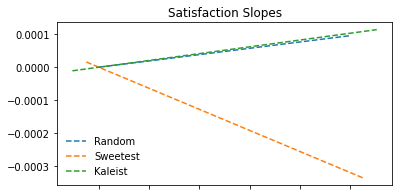

In [10]:
fig, ax = plt.subplots(1,1,figsize=(6,3))
abline(9.586121434477154e-05, 0, "Random")
abline(-0.0003199796162644487, 0, "Sweetest")
abline(0.00010328813181183704 , 0, "Kaleist")

<b>Get an environment baseline</b>

It is always best practice, before training an algorithm, to run through the environment and record the mean reward as a baseline.

<div class="alert alert-block alert-success">
💡 For this environment, we will calculate 3 baselines: <br>
    <ul>
        <li>Random baseline: pick randomly every time</li>
        <li>Greedy sweet baseline: always pick the sweetest item </li>
        <li>Greedy kale baseline: always pick the kaleist item </li>
    </ul>
</div>

In [11]:
# Function that measures and outputs the random baseline reward.
# This is the expected accumulated reward per episode, if we act randomly (recommend random items) at each time step.
def calc_baseline(env, 
                  baseline_type="random",
                  episodes=100, verbose=False):

    # Reset the env.
    obs = env.reset()
    doc_list = [t[1][0] for t in list(obs['doc'].items()) ]

    # Number of episodes already done.
    num_episodes = 0
    # Current episode's accumulated reward.
    episode_reward = 0.0
    # Collect all episode rewards here to be able to calculate a random baseline reward.
    episode_rewards = []
    # Keep track of sugar consumed
    episode_sugar = 0.0
    doc_sugar = []
    
    # Enter while loop (to step through the episode).
    while num_episodes < episodes:
        # Produce an action
        # action_random = env.action_space.sample()
        action_random = random.randint(0, len(doc_list)-1)
        action_sweetest = np.argmax(doc_list)
        action_kaleiest = np.argmin(doc_list)
        if baseline_type == "random":
            action = action_random
        elif baseline_type == "sweetest":
            action = action_sweetest
        elif baseline_type == "kaleist":
            action = action_kaleiest
        sugar = doc_list[action]
        # # debugging
        # print(f"doc_val={doc_list[action]}")
        # print(np.argmax(doc_list), doc_list)
        
        # Send the action to the env's `step()` method to receive: obs, reward, done, and info.
        obs, reward, done, _ = env.step(action)
        doc_list = [t[1][0] for t in list(obs['doc'].items()) ]
        episode_reward += reward
        episode_sugar += sugar
        
        # Check, whether the episde is done, if yes, reset and increase episode counter.
        if done:
            if verbose:
                print(f"Episode done - accumulated reward={episode_reward}")
            elif num_episodes % 99 == 0:
                print(f" {num_episodes} ", end="")
            elif num_episodes % 9 == 0:
                print(".", end="")
                
            # increment on end of episode
            num_episodes += 1
            obs = env.reset()
            episode_rewards.append(episode_reward)
            episode_reward = 0.0
            doc_sugar.append(episode_sugar)
            episode_sugar = 0.0

    # Print out and return mean episode reward (and standard error of the mean).
    env_mean_reward = np.mean(episode_rewards)
    env_sd_reward = np.std(episode_rewards)
    
    # Print out sugar consumed
    env_mean_sugar_consumed = np.mean(doc_sugar)
    env_sd_sugar = np.std(doc_sugar)

    print(f"\nMean {baseline_type} baseline reward: {env_mean_reward:.2f}+/-{env_sd_reward:.2f}")
    print(f"Mean {baseline_type} sugar consumed: {env_mean_sugar_consumed:.2f}+/-{env_sd_sugar:.2f}")

    return env_mean_reward, episode_rewards


In [12]:
# Calculate a baseline type: random, sweetest, or kaleist
start_time = time.time()

lts_20_2_mean_kaleist_reward, lts_20_2_mean_kaleist_rewards = \
    calc_baseline(modified_lts_20_2_env, 
                  baseline_type="kaleist",
                  episodes=100)
lts_20_2_mean_random_reward, lts_20_2_mean_random_rewards = \
    calc_baseline(modified_lts_20_2_env, 
                  baseline_type="random",
                  episodes=100)
lts_20_2_mean_sweetest_reward, lts_20_2_mean_sweetest_rewards = \
    calc_baseline(modified_lts_20_2_env, 
                  baseline_type="sweetest",
                  episodes=100)

print(f"Environment by itself took {time.time() - start_time:.2f} seconds")

# Mean kaleist baseline reward: 1082.38+/-9.70  # smallest
# Mean kaleist sugar consumed: 5.71+/-0.50
# Mean random baseline reward: 1158.59+/-10.82 # next biggest
# Mean random sugar consumed: 60.07+/-3.70
# Mean sweetest baseline reward: 1163.77+/-10.93 # biggest
# Mean sweetest sugar consumed: 114.29+/-0.51

 0 .......... 99 
Mean kaleist baseline reward: 1082.38+/-9.70
Mean kaleist sugar consumed: 5.71+/-0.50
 0 .......... 99 
Mean random baseline reward: 1158.59+/-10.82
Mean random sugar consumed: 60.07+/-3.70
 0 .......... 99 
Mean sweetest baseline reward: 1163.77+/-10.93
Mean sweetest sugar consumed: 114.29+/-0.51
Environment by itself took 14.38 seconds


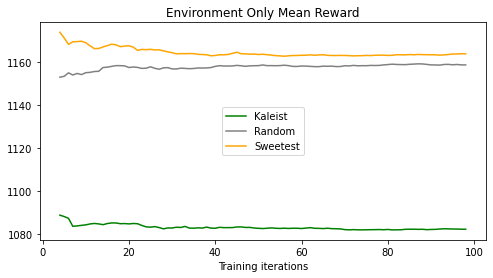

In [34]:
# Plot per-timestep (episode) rewards.
fig, ax = plt.subplots(1,1,figsize=(8,4))

# collect plot data from rewards
start_at = 4
smoothing_win = 100

# plot rewards
x = list(range(start_at, len(lts_20_2_mean_sweetest_rewards)-1))
y = [np.nanmean(lts_20_2_mean_sweetest_rewards[max(i - smoothing_win, 0):i + 1]) 
     for i in range(start_at, len(lts_20_2_mean_sweetest_rewards)-1)]
ax.plot(x, y, label="Sweetest", color="orange")

x = list(range(start_at, len(lts_20_2_mean_random_rewards)-1))
y = [np.nanmean(lts_20_2_mean_random_rewards[max(i - smoothing_win, 0):i + 1]) 
     for i in range(start_at, len(lts_20_2_mean_random_rewards)-1)]
ax.plot(x, y, label="Random", color="grey")

x = list(range(start_at, len(lts_20_2_mean_kaleist_rewards)-1))
y = [np.nanmean(lts_20_2_mean_kaleist_rewards[max(i - smoothing_win, 0):i + 1]) 
     for i in range(start_at, len(lts_20_2_mean_kaleist_rewards)-1)]
ax.plot(x, y, label="Kaleist", color="green")

# # Add mean random baseline reward (red line).
# plt.axhline(y=lts_20_2_mean_random_reward, 
#             color="r", 
#             linestyle="-",
#             label="Random baseline")

# Add legend
ax.legend(loc='center', frameon=True)

# Add titles
plt.title("Environment-only Mean Reward")
plt.xlabel("Training iterations")

plt.plot();

## Train a Contextual Bandit on the environment <a class="anchor" id="cb"></a>

A Bandit session is one where we have an opportunity to recommend to the user an item and receive a reward if they click.

<img src="./images/simple_n_armed_bandit.png" width="90%" />

<ol>
    <li>Open RLlib docs <a href="https://docs.ray.io/en/master/rllib/rllib-algorithms.html">and navigate to the Algorithms page.</a></li>
    <li>Scroll down and click url of algo you want to use, e.g. <i><b>Bandits</b></i></li>
    <li>On the <a href="https://docs.ray.io/en/master/rllib/rllib-algorithms.html#bandits">algo docs page </a>, click on the link <i><b>Implementation</b></i>.  This will open the <a href="https://github.com/ray-project/ray/blob/master/rllib/algorithms/bandit/bandit.py">algo code file on github</a>.</li>
    <li>Search the github code file for the word <i><b>config</b></i></li>
    <li>Typically the docstring example will show: </li>
    <ol>
        <li>Example code implementing RLlib API, then </li>
        <li>Example code implementing Ray Tune API.</li>
    </ol>
    <li>Scroll down to the config <b>__init()__</b> method</li>
    <ol>
            <li>Algorithm default hyperparameter values are here.</li>
    </ol>
    </ol>

In [14]:
# Select RLlib Bandit algorithm w/Upper Confidence Bound (UCB) exploration
# and find that algorithm's config class

# config is an object instead of a dictionary since Ray version >= 1.13
from ray.rllib.algorithms.bandit.bandit import BanditLinUCBConfig

In [15]:
# # uncomment below to see the long list of default config values
# print(f"Bandit's default config is:")
# print(pretty_print(BanditLinUCBConfig().to_dict()))

# Create a Bandit object
bandit_config = BanditLinUCBConfig()

# Setup our config object to use our environment
env_config_20 = \
    {
        # The number of possible documents/videos/candidates that we can recommend
        "num_candidates": 20,  
        # The number of recommendations that we will be making
        "slate_size": 2,  # MultiDiscrete([20, 20]) -> Discrete(400)
        # Set to False for re-using the same candidate doecuments each timestep.
        "resample_documents": True,
        # Convert MultiDiscrete actions to Discrete (flatten action space).
        "convert_to_discrete_action_space": True,
        # Wrap observations for RLlib bandit: Only changes dict keys ("item" instead of "doc").
        "wrap_for_bandits": True,
        # Use consistent seeds for the environment ...
        "seed": 0,}

# Set it up for the correct environment:
bandit_config.environment(env="modified-lts", env_config=env_config_20)

# Decide if you want torch or tensorflow DL framework.  Default is "tf"
bandit_config.framework("torch")

# Setup evaluation
# Explicitly set "explore"=False to override default
bandit_config.evaluation(
    evaluation_interval=10, 
    evaluation_duration=20, 
    evaluation_duration_unit="timesteps",)
    # evaluation_config = {"explore" : False})

# Setup sampling rollout workers
# +1 for head node, num parallel workers or actors for rollouts
bandit_config.rollouts(\
    num_rollout_workers=1,
    num_envs_per_worker=1,)
    # enable_connectors=True)

bandit_config.resources(num_gpus=0)

# Set the log level to DEBUG, INFO, WARN, or ERROR 
# seed the algorithm / policy
bandit_config.debugging(seed=415, log_level="ERROR")

# for increasing logging frequency in the terminal for this tutorial
bandit_config.reporting(
    min_train_timesteps_per_iteration=1,
    metrics_num_episodes_for_smoothing=2) #200


In [ ]:
# SINGLE .TRAIN() OUTPUT

# instantiate an algo instance
linucb_algo = bandit_config.build()
print(f"Algorithm type: {type(linucb_algo)}")

# Perform single `.train() iteration` call
# Result is a Python dict object
result = linucb_algo.train()

# Erase config dict from result (for better overview).
del result["config"]
# Print out training iteration results.
print(pretty_print(result))

In [17]:
###############
# EXAMPLE USING RLLIB API .train() IN A LOOP
# To train for N number of episodes, you put .train() into a loop, 
# similar to the way we ran the Gym env.step() in a loop.
###############
# # start fresh in case ray already running
# if ray.is_initialized():
#     ray.shutdown()

start_time = time.time()

# Use the config object's `build()` method for generating
# an RLlib Algorithm instance that we can then train.
linucb_algo = bandit_config.build()
print(f"Algorithm type: {type(linucb_algo)}")

# train the Algorithm instance for 100 iterations
num_iterations = 100
rewards = []
checkpoint_dir = "results/bandit_recsim/"

for i in range(num_iterations):
    # Call its `train()` method
    result = linucb_algo.train()
    
    # Extract reward from results.
    rewards.append(result["episode_reward_mean"])
    
    # print something every 10 episodes
    if (((i % 10 == 0) and (i >=4)) or (i == num_iterations-1)):
        print(f"Iteration={i}, Mean Reward={result['episode_reward_mean']:.2f}",end="")
        try:
            print(f"+/-{np.std(rewards[4:]):.2f}")
        except:
            print("")
        # save checkpoint file
        checkpoint_file = linucb_algo.save(checkpoint_dir)
        print(f"Checkpoints saved at {checkpoint_file}")
        # evaluate the policy
        eval_result = linucb_algo.evaluate()

# convert num_iterations to num_episodes
num_episodes = len(result["hist_stats"]["episode_lengths"]) * num_iterations
# convert num_iterations to num_timesteps
num_timesteps = sum(result["hist_stats"]["episode_lengths"] * num_iterations)
# calculate cumulative sum rewards
total_return = np.sum(result["hist_stats"]["episode_reward"])

# train time
print(f"Bandit Return {total_return} over {num_episodes} episodes ({num_timesteps} timesteps)") 
print(f"Approx {total_return/num_episodes:.2f} Return per episode")
print(f"Training took {time.time() - start_time:.2f} seconds")


# # Uncomment to train and generate the json output.
# """
# algo = dummy_config.build()

# for _ in range(4):
#     algo.train()
# """

Algorithm type: <class 'ray.rllib.algorithms.bandit.bandit.BanditLinUCB'>
Iteration=10, Mean Reward=1148.91+/-7.92
Checkpoints saved at results/bandit_recsim/checkpoint_000011
Iteration=20, Mean Reward=1167.48+/-8.15
Checkpoints saved at results/bandit_recsim/checkpoint_000021
Iteration=30, Mean Reward=1165.22+/-6.77
Checkpoints saved at results/bandit_recsim/checkpoint_000031
Iteration=40, Mean Reward=1148.79+/-6.84
Checkpoints saved at results/bandit_recsim/checkpoint_000041
Iteration=50, Mean Reward=1165.07+/-7.02
Checkpoints saved at results/bandit_recsim/checkpoint_000051
Iteration=60, Mean Reward=1169.95+/-6.74
Checkpoints saved at results/bandit_recsim/checkpoint_000061
Iteration=70, Mean Reward=1156.46+/-7.29
Checkpoints saved at results/bandit_recsim/checkpoint_000071
Iteration=80, Mean Reward=1164.03+/-7.42
Checkpoints saved at results/bandit_recsim/checkpoint_000081
Iteration=90, Mean Reward=1158.23+/-7.18
Checkpoints saved at results/bandit_recsim/checkpoint_000091
Iteratio

<b>Compare the Bandit Training results to Baseline <br></b>
- Bandit Mean Reward=~1166.01+/-6.94. 
> Kaleist Baseline Mean Reward = ~1082.38+/-9.70 (out of success=6000)<br>
Random Baseline Mean Reward = ~1158.59+/-10.82 (out of success=6000)<br>
Sweetest Baseline Mean Reward = ~1163.77+/-10.93 (out of success=6000)<br>

<div class="alert alert-block alert-success">
    🤔  <b>Bandit mean reward is approx the same as the sweetest baseline!</b> <br>
</div>  

<br>
Try the code block below to compare what the bandit recommends with what is the sweetest item... you will see that the bandit always recommends the sweetest item!

In [ ]:
# Let's see what items our bandit recommends now that it has been trained and achieves good (>> random) rewards.
obs = modified_lts_20_2_env.reset()

# Run a single episode.
done = False
while not done:
    # Pass the single (unbatched) observation into the `compute_single_action` method of our Trainer.
    # This is one way to perform inference on a learned policy.
    action = linucb_algo.compute_single_action(input_dict={"obs": obs})
    feat_value_of_action = obs["item"][action][0]
    max_choc_feat = obs['item'][np.argmax(obs["item"])][0]

    # Print out the picked document's feature value and compare that to the highest possible feature value.
    print(f"action's feature value={feat_value_of_action}; max-choc-feature={max_choc_feat}; ")

    # Apply the computed action in the environment and continue.
    obs, r, done, _ = lts_20_2_env.step(action)
    

In this dummy Recsim environment, we did not have any user features.  This makes the contextual bandit without any user context, i.e. without any state.  A stateless bandit cannot remember things between timesteps, so it will be exactly the most greedy policy.

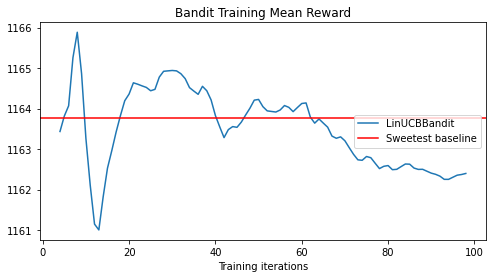

In [35]:
# Plot per-timestep (episode) rewards.
fig, ax = plt.subplots(1,1,figsize=(8,4))

# collect plot data from bandit rewards
start_at = 4  #bandit rewards are nan for 1st 3 iterations
smoothing_win = 100
x = list(range(start_at, len(rewards)-1))
y = [np.nanmean(rewards[max(i - smoothing_win, 0):i + 1]) 
     for i in range(start_at, len(rewards)-1)]

# plot bandit rewards
ax.plot(x, y, label="LinUCBBandit")

# Add mean random baseline reward (red line).
plt.axhline(y=lts_20_2_mean_sweetest_reward, 
            color="r", 
            linestyle="-",
            label="Sweetest baseline")

# Add legend
ax.legend(loc='center right', frameon=True)

# Add titles
plt.title("Bandit Training Mean Reward")
plt.xlabel("Training iterations")

plt.plot();


In [19]:
# To stop the Algorithm and release its blocked resources, use:
linucb_algo.stop()
print()

## Train using a RL SlateQ algorithm on the environment <a class="anchor" id="slateq"></a>

The RLlib team has implemented the Slate-Q algorithm from Google - Deep Q-Learning (DQN) designed for k-slate, long time horizon, and dynamic user recommendation problems.

<a href="https://storage.googleapis.com/pub-tools-public-publication-data/pdf/9f91de1fa0ac351ecb12e4062a37afb896aa1463.pdf">Slate-Q Paper</a> <br>
<a href="https://slideslive.com/38917655/reinforcement-learning-in-recommender-systems-some-challenges">Author video</a> about Slate-Q <br>
<a href="https://www.anyscale.com/blog/reinforcement-learning-with-deep-q-networks">Anyscale tutorial blog explanation of Deep Q-Learning (DQN)</a>

<img src="./images/slateq_with_DQN_equations.png" width="100%" />
<br>

In [ ]:
# config is an object instead of a dictionary since Ray version >= 1.13
from ray.rllib.algorithms.slateq.slateq import SlateQConfig

In [ ]:
# Create a SlateQConfig object
slateq_config = SlateQConfig()

# Setup our config object to use our environment
slateq_config.environment(
        env="modified-lts", 
        env_config={
            # The number of possible documents/videos/candidates that we can recommend
            "num_candidates": 20,  
            # The number of recommendations that we will be making
            "slate_size": 2,  # MultiDiscrete([20, 20]) -> Discrete(400)
            # Set to False for re-using the same candidate doecuments each timestep.
            "resample_documents": True,
            # Convert MultiDiscrete actions to Discrete (flatten action space).
            # SlateQ handles MultiDiscrete action spaces (slate recommendations).
            "convert_to_discrete_action_space": False,
            # Wrap observations for RLlib bandit: Only changes dict keys ("item" instead of "doc").
            # SlateQ != Bandit (will keep "doc" key, instead of "items")
            "wrap_for_bandits": False,
            # Use consistent seeds for the environment ...
            "seed": 0,})

# Decide if you want torch or tensorflow DL framework.  Default is "tf"
slateq_config.framework(framework="torch")

# Set the log level to DEBUG, INFO, WARN, or ERROR 
# seed the algorithm / policy
slateq_config.debugging(seed=415, log_level="INFO")

# Setup evaluation
# Explicitly set "explore"=False to override default
slateq_config.evaluation(
    # evaluation_interval=10, 
    # evaluation_duration=20, 
    # evaluation_duration_unit="timesteps",
    evaluation_config = {"explore" : False})

# Setup sampling rollout workers
# +1 for head node, num parallel workers or actors for rollouts
slateq_config.rollouts(
    num_rollout_workers=1,
    num_envs_per_worker=1,)
    # enable_connectors=True)

slateq_config.resources(num_gpus=0)

# Setup target network training
slateq_config.training(target_network_update_freq=3200)

# Setup exploration
slateq_config.exploration(explore=True,
                 exploration_config={
                  # You could use Ray Tune to run 3 parallel tuning trials
                  # epsilon_timesteps=tune.grid_search([30000, 60000, 3000]),  # default: 250000
                  "epsilon_timesteps": 60000,  
                 })

# for increasing logging frequency in the terminal for this tutorial
slateq_config.reporting(
    min_train_timesteps_per_iteration=1,
    metrics_num_episodes_for_smoothing=100) #200



Now that we have confirmed we have setup the Trainer correctly, let's call train() on it for one iteration to inspect a single result.

💡 <b>Right-click on the cell below and choose "Enable Scrolling for Outputs"!</b>  This will make it easier to view, since model training output can be very long!

In [ ]:
# SINGLE .TRAIN() OUTPUT

# instantiate an algo instance
slateq_algo = slateq_config.build()
print(f"Algorithm type: {type(slateq_algo)}")

start_time = time.time()

# Perform single `.train() iteration` call
# Result is a Python dict object
result = slateq_algo.train()

# train time
print(f"Training took {time.time() - start_time:.2f} seconds")

# Erase config dict from result (for better overview).
del result["hist_stats"]
del result["config"]
# Print out training iteration results.
print(pretty_print(result))

# Training took 168.93 seconds for 1 single iteration

Now that we have confirmed we have setup the Trainer correctly, let's call train() on it 30 times:

In [ ]:
# Train using Ray Tune

start_time = time.time()

# You can change timesteps_total here to see more tuning
experiment_results = tune.run("SlateQ", 
                              
        # training config params (translated into a python dict!)
        config=slateq_config.to_dict(), 
         
        # Stopping criteria whichever occurs first:
        stop={"timesteps_total":600000, 
              "training_iteration":30},
         
        # redirect logs instead of default ~/ray_results/
        local_dir="results/slateq_recsim",

        # Always save last checkpoint (no matter the frequency).
        checkpoint_at_end=True,

        ###############
        # Note about Ray Tune verbosity.
        # Screen verbosity in Ray Tune is defined as verbose = 0, 1, 2, or 3, where:
        # 0 = silent
        # 1 = only status updates, no logging messages
        # 2 = status and brief trial results, includes logging messages
        # 3 = status and detailed trial results, includes logging messages
        # Defaults to 3.
        ###############
        verbose=3,

        # Define what we are comparing for, when we search for the
        # "best" checkpoint at the end.
        metric="episode_reward_mean",
        mode="max",
        )

# train time
print(f"Training took {time.time() - start_time:.2f} seconds")

# Training 10 iterations took 486.55 seconds; approx 8 minutes
# Training 30 iterations took 1174.30 seconds; approx 20 minutes

In [24]:
# # Train using RLlib API .train()

# start_time = time.time()

# # See reward progress with time
# # Run `train()` n times. Repeatedly call `train()` now to see rewards increase.
# for _ in range(60):
#     results = slateq_algo.train()
#     print(f"Iteration={slateq.iteration}; ts={results['timesteps_total']}: R(\"return\")={results['episode_reward_mean']}")
    
# # train time
# print(f"Training took {time.time() - start_time:.2f} seconds")

In [ ]:
# Read trainer results in a pandas dataframe
df = experiment_results.results_df
print(f"df.shape: {df.shape}")  #Only 1 trial

print(df.columns.tolist())
df.iloc[:,0:8].head()

In [26]:
# found the rewards?
df['sampler_results/hist_stats/episode_reward'][0][0:10]

[1136.4399915339754,
 1179.8849388140854,
 1166.8024604474872,
 1165.9900390035946,
 1183.8831479554556,
 1167.892385320542,
 1173.6663509466946,
 1144.0642684658858,
 1157.9853816020693,
 1175.0277593525238]

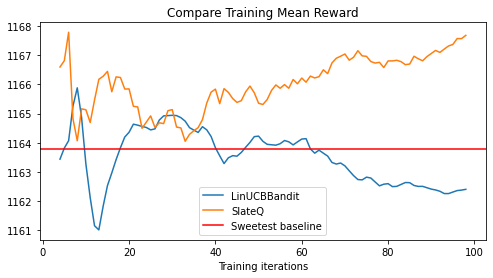

In [42]:
# Plot per-timestep (episode) rewards.
fig, ax = plt.subplots(1,1,figsize=(8,4))

# collect plot data from bandit rewards
start_at = 4  #bandit rewards are nan for 1st 3 iterations
smoothing_win = 100

x = list(range(start_at, len(rewards)-1))
y = [np.nanmean(rewards[max(i - smoothing_win, 0):i + 1]) 
     for i in range(start_at, len(rewards)-1)]
# plot bandit rewards
ax.plot(x, y, label="LinUCBBandit")

rewards_slateq = df['sampler_results/hist_stats/episode_reward'][0]
x = list(range(start_at, len(rewards_slateq)-1))
y = [np.nanmean(rewards_slateq[max(i - smoothing_win, 0):i + 1]) 
     for i in range(start_at, len(rewards_slateq)-1)]
# plot bandit rewards
ax.plot(x, y, label="SlateQ")

# Add mean random baseline reward (red line).
plt.axhline(y=lts_20_2_mean_sweetest_reward, 
            color="r", 
            linestyle="-",
            label="Sweetest baseline",)

# Add legend
ax.legend(loc='lower center', frameon=True)

# Add titles
plt.title("Compare Training Mean Reward")
plt.xlabel("Training iterations")

plt.plot();

In [28]:
# To stop the Algorithm and release its blocked resources, use:
slateq_algo.stop()
print()

# Offline RL in RecSys

To be continued in a few weeks at the [ACM RecSys Conference](https://recsys.acm.org/recsys22/tutorials/) in Seattle!
<br>

📖 [Back to Table of Contents](./ex_00_rllib_notebooks_table_of_contents.ipynb)<br>
➡️ [Next notebook](./ex_07_rllib_end_to_end_demo.ipynb) <br>
⬅️ [Previous notebook](./ex_05_rllib_and_ray_serve.ipynb) <br>